In [9]:
# Load necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.tokenize import word_tokenize

In [103]:
df_train = pd.read_pickle("./data_frames/df_train.pkl")
df_test = pd.read_pickle("./data_frames/df_test.pkl")
df_dp_train = pd.read_pickle("./data_frames/dependency_parsing/df_dp_train.pkl")
df_dp_test = pd.read_pickle("./data_frames/dependency_parsing/df_dp_test.pkl")

In [104]:
def plot_normalized_overlap(df, title, bins, type):
    o_len = df[type+'_overlap_count'].values
    max_len = np.minimum(df[type+'_ans_wordcount'].values, df[type+'_q_wordcount'].values)
    frac_len = o_len/max_len
    # print('frac_len: ', frac_len)
    mean = np.nanmean(frac_len)
    print('mean: ', mean)
    # flat_list = [item for sublist in locations for item in sublist]
    plt.hist(frac_len, density=True, bins=bins)
    plt.axvline(mean, color='g', linestyle='dashed', linewidth=1, label='mean: {:.2f}'.format(mean))
    plt.ylabel('Vol')
    plt.xlabel('Fraction of words overlapping')
    plt.legend()
    plt.title(title)
    plt.show()

In [105]:
def find_overlap_sent(a_w, q_w):
    overlap = 0
    overlap_w = []
    for w in a_w:
        if w in q_w:
            overlap += 1
            overlap_w.append(w)
    return overlap, overlap_w


# find the number of overlapping words between sent_with_ans / question / correct_answer
def find_word_overlap_base(df):
    overlap_nr = []
    overlap_words = []
    tot_ans_words_arr = []
    tot_q_words_arr = []
    for index, row in df.iterrows():
        q = row['question'].lower()
        a = row['sent_with_ans'].lower()
        a = re.sub('[^\sa-zåäöA-ZÅÄÖ1-9]', '', a)
        q = re.sub('[^\sa-zåäöA-ZÅÄÖ1-9]', '', q)
        # split in to words
        q_w = word_tokenize(q)
        a_w = word_tokenize(a)
        q_w = list(dict.fromkeys(q_w)) # remove duplicate words
        a_w = list(dict.fromkeys(a_w)) # remove duplicate words

        tot_ans_words_arr.append(len(a_w))
        tot_q_words_arr.append(len(q_w))
        overlap, overlap_w = find_overlap_sent(a_w, q_w)
        
        overlap_words.append(overlap_w)
        overlap_nr.append(overlap)
    
    return overlap_nr, overlap_words, tot_ans_words_arr, tot_q_words_arr

df_train['base_overlap_count'], df_train['base_overlap_words'], df_train['base_ans_wordcount'], df_train['base_q_wordcount'] = find_word_overlap_base(df_train)
df_test['base_overlap_count'], df_test['base_overlap_words'], df_test['base_ans_wordcount'], df_test['base_q_wordcount'] = find_word_overlap_base(df_test)


In [106]:
# find overlap using the lemmatized versions of the answer sentences and questions
def find_word_overlap_lemmatized(df):
    overlap_nr = []
    overlap_words = []
    tot_ans_words_arr = []
    tot_q_words_arr = []
    for index, row in df.iterrows():
        q_w = row['q_words']
        a_w = row['sent_words']
        q_w = list(dict.fromkeys(q_w)) # remove duplicate words
        a_w = list(dict.fromkeys(a_w)) # remove duplicate words
        tot_ans_words_arr.append(len(a_w))
        tot_q_words_arr.append(len(q_w))
        overlap, overlap_w = find_overlap_sent(a_w, q_w)
        
        overlap_words.append(overlap_w)
        overlap_nr.append(overlap)
    
    return overlap_nr, overlap_words, tot_ans_words_arr, tot_q_words_arr

df_train['lemma_overlap_count'], df_train['lemma_overlap_words'], df_train['lemma_ans_wordcount'], df_train['lemma_q_wordcount'] = find_word_overlap_lemmatized(df_dp_train)
df_test['lemma_overlap_count'], df_test['lemma_overlap_words'], df_test['lemma_ans_wordcount'], df_test['lemma_q_wordcount'] = find_word_overlap_lemmatized(df_dp_test)


mean:  0.5630919543502897


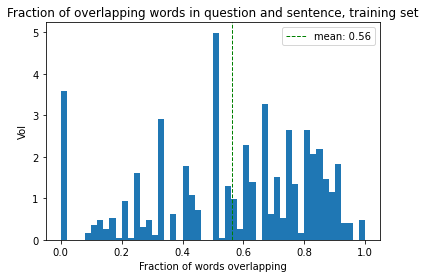

mean:  0.6135334346100108


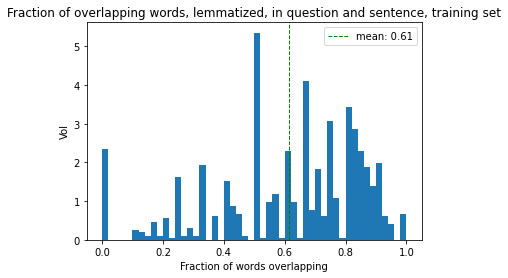

mean:  0.5579030541306756


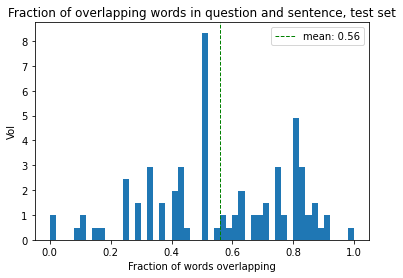

mean:  0.6092286892798402


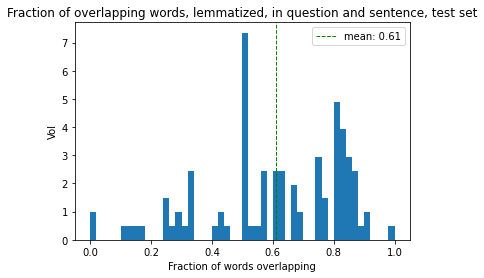

In [107]:
plot_normalized_overlap(df_train, 'Fraction of overlapping words in question and sentence, training set', 50, 'base')
plot_normalized_overlap(df_train, 'Fraction of overlapping words, lemmatized, in question and sentence, training set', 50, 'lemma')
plot_normalized_overlap(df_test, 'Fraction of overlapping words in question and sentence, test set', 50, 'base')
plot_normalized_overlap(df_test, 'Fraction of overlapping words, lemmatized, in question and sentence, test set', 50, 'lemma')

In [108]:
# find the question answer pairs where there is no / little overlap in words
def print_overlap(filename, df, type):
    with open(filename, 'w') as out:
        for index, row in df.iterrows():
            out.write('-------------------'+ '\n')
            out.write('overlapping words: ' + ' '.join(row[type+'_overlap_words']) + '\n')
            out.write('question: ' + row['question'] + '\n')
            out.write('answer: ' + row['correct_answer'] + '\n')
            out.write('sentence with answer: '+ row['sent_with_ans']+ '\n')

# pd.set_option("display.max_rows", None, "display.max_columns", None)

df_train_little_overlap = df_train.loc[df_train['lemma_overlap_count'] == 0]
print_overlap('figures/question-answer-pairs-no-overlap-lemma.txt', df_train_little_overlap, 'lemma')

df_train_little_overlap_base = df_train.loc[df_train['base_overlap_count'] == 0]
print_overlap('figures/question-answer-pairs-no-overlap-base.txt', df_train_little_overlap_base, 'base')